# Spectral analysis of bivariate signals tutorial

This tutorial aims at demonstrating different tools available within the `spectral` module of `BisPy`. The examples provided here come along with the paper

* Julien Flamant, Nicolas Le Bihan, Pierre Chainais: “Spectral analysis of stationary random bivariate signals”, 2017; [arXiv:1703.06417]( http://arxiv.org/abs/1703.06417).

The paper contains theoretical results and several applications that can be reproduced with the following tutorial. 
If you use `BisPy` for your research, please cite the above paper as reference.
            

## Load `bispy` and necessary modules

In [1]:
%pylab inline
%load_ext autoreload
%autoreload 2
import quaternion  # load the quaternion module
figsize(4,4)

import sys
sys.path.append('/Users/Julien/Documents/Recherche/These/Codes/pytb_dev/')
import bispy as bsp

Populating the interactive namespace from numpy and matplotlib


## Synthetic examples

The following examples are presented in the aforementioned paper. The module `bispy.utils` gives useful functions to generate the synthetic signals presented.

### Example 1: Bivariate white noise only

First let us define the constants defining the polarization properties of the bivariate white gaussian noise.

In [2]:
N = 1024 # length of the signal
S0 = 1 # power of the bivariate WGN
P0 = .5 # degree of polarization
theta0 = pi/4 # angle of linear polarization

t = np.arange(0, N) # time vector

First simulate a realization of this bivariate WGN (note the use of the argument `complexOutput` which provides a complex output (useful for plots), rather than a quaternion-valued output (useful for computations)

In [3]:
w = bsp.utils.bivariatewhiteNoise(N, S0, P=P0, theta=theta0, complexOutput=True)

Now, display this signal

Text(0,0.5,'imaginary axis')

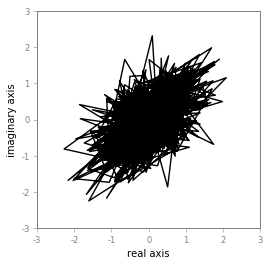

In [4]:
fig, ax = plt.subplots()

ax.plot(w.real, w.imag, color='k')

ax.set_xlim([-3, 3])
ax.set_ylim([-3, 3])
ax.set_xlabel('real axis')
ax.set_ylabel('imaginary axis')

The goal is now to compare 2 spectral density estimation methods: 

 - an averaged polarization periodogram 
 - an averaged multitaper estimate using Slepian tapers. 

To do so, we simulate `M` independent realization of this bivariate WGN, and average across realizations each method output.

In [5]:
M = 10 # number of independent realization of the WGN

The periodogram and multitaper estimates are computed like:

In [6]:
w = bsp.utils.bivariatewhiteNoise(N, S0, P=P0, theta=theta0)
# compute spectral estimates
per = bsp.spectral.Periodogram(t, w) 
multi = bsp.spectral.Multitaper(t, w)

# loop accros realizations
for k in range(1, M):
    w = bsp.utils.bivariatewhiteNoise(N, S0,  P=P0, theta=theta0)
    
    per2 = bsp.spectral.Periodogram(t, w)
    multi2 = bsp.spectral.Multitaper(t, w)
    per = per + per2
    multi = multi + multi2

# normalize by M
per = 1./M * per
multi = 1./M * multi

Number of data tapers: 4
Number of data tapers: 4
Number of data tapers: 4
Number of data tapers: 4
Number of data tapers: 4
Number of data tapers: 4
Number of data tapers: 4
Number of data tapers: 4
Number of data tapers: 4
Number of data tapers: 4


By default, the `Multitaper` class assumes a bandwidth `bw` of 2.5 frequency samples, giving 4 Slepian tapers. 

The next step is to normalize the Stokes parameters $S_1, S_2, S_3$ by the intensity Stokes parameter $S_0$

In [7]:
per.normalize()
multi.normalize()

We can now display the results for both methods

//anaconda/lib/python3.5/site-packages/matplotlib/figure.py:418: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


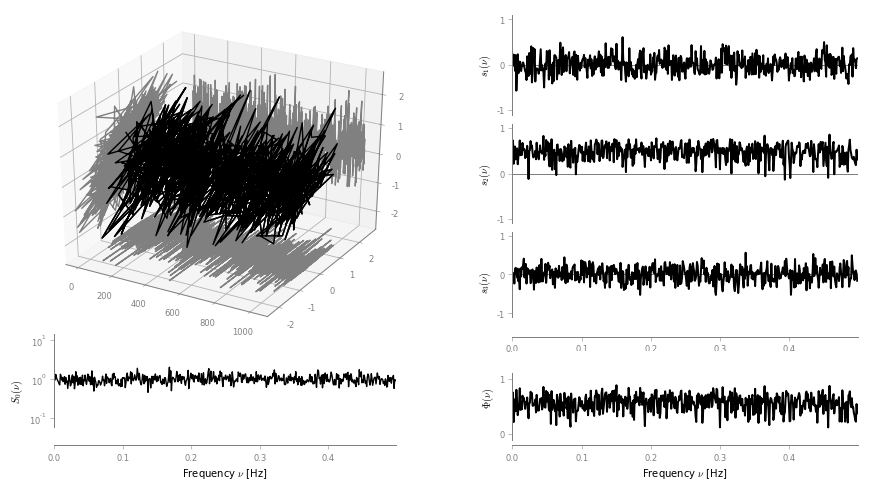

In [8]:
fig, axes = per.plot()

//anaconda/lib/python3.5/site-packages/matplotlib/figure.py:418: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


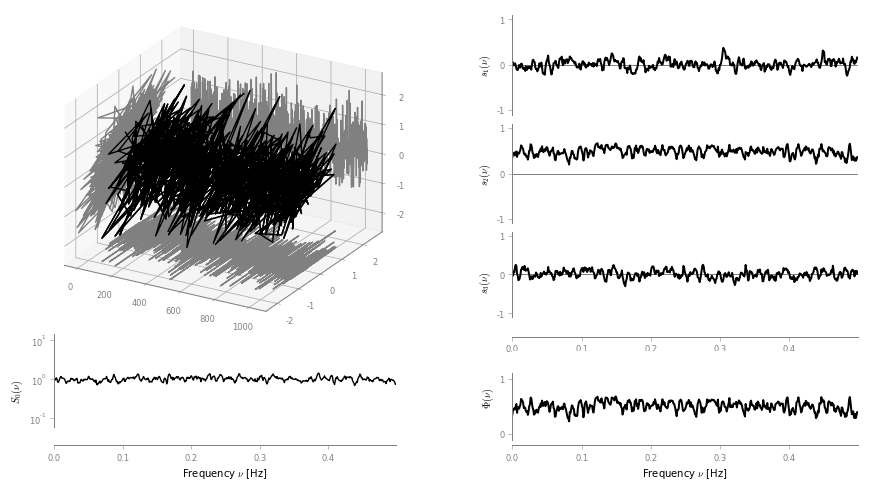

In [9]:
fig, ax = multi.plot()

Both estimates permits to recover the main features of the bivariate WGN: power, degree of polarization and polarization state are recovered. 

Then the usual discussion between periodogram and multitaper estimates apply: the multitaper estimate exhibits reduced leakage bias and less variance than the periodogram estimate.

### Example 2: bivariate monochromatic signal in white noise

We proceed similarly. First define the different parameters:

In [10]:
N = 1024 # length of the signal

t = np.arange(0, N) # time vector
dt = (t[1]-t[0])

# bivariate monochromatic signal parameters
a = 1/sqrt(N*dt) # amplitude = 1
theta = -pi/3 # polarization angle
chi = pi/8 # ellipticity parameter
f0 = 128/N/dt # frequency

# bivariate WGN noise paramerters
S0_w = 10**(-2) # power of the bivariate WGN
Phi_w = .2 # degree of polarization
theta_w = pi/8 # angle of linear polarization

Now, simulate a bivariate monochromatic signal (note the use of the argument `complexOutput` which provides a complex output (useful for plots), rather than a quaternion-valued output (useful for computations)

In [11]:
x = bsp.utils.bivariateAMFM(a, theta, chi, 2*np.pi*f0*t, complexOutput=True, Hembedding=False)

Let us have a look at the bivariate signal itself

Text(0,0.5,'imaginary axis')

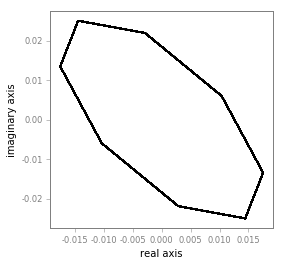

In [12]:
fig, ax = plt.subplots()
ax.plot(x.real, x.imag, color='k')

ax.set_xlabel('real axis')
ax.set_ylabel('imaginary axis')

Again, we compare 2 spectral density estimation methods: 

 - an averaged polarization periodogram 
 - an averaged multitaper estimate using Slepian tapers. 

To do so, we simulate `M` independent realization of this bivariate WGN, and average across realizations each method output.

In [13]:
M = 20 # number of realizations
y = np.zeros((N, M), dtype='quaternion')

# generate the data
for k in range(M):
    phi = 2*np.pi*np.random.rand() # random initial phase term
    x = bsp.utils.bivariateAMFM(a, theta, chi, 2*np.pi*f0*t+phi) # bivariate monochromatic signal
    w = bsp.utils.bivariatewhiteNoise(N, S0_w, Phi_w, theta_w) # bivariate WGN
    y[:, k] = x + w

# compute spectral estimates
per = bsp.spectral.Periodogram(t, y[:, 0])
multi = bsp.spectral.Multitaper(t, y[:, 0], bw=3) 
for k in range(1, M):
    per2 = bsp.spectral.Periodogram(t, y[:, k])
    multi2 = bsp.spectral.Multitaper(t, y[:, k], bw=3)
    
    per = per + per2
    multi = multi + multi2

    
per = 1./M * per
multi = 1/M * multi

Number of data tapers: 5
Number of data tapers: 5
Number of data tapers: 5
Number of data tapers: 5
Number of data tapers: 5
Number of data tapers: 5
Number of data tapers: 5
Number of data tapers: 5
Number of data tapers: 5
Number of data tapers: 5
Number of data tapers: 5
Number of data tapers: 5
Number of data tapers: 5
Number of data tapers: 5
Number of data tapers: 5
Number of data tapers: 5
Number of data tapers: 5
Number of data tapers: 5
Number of data tapers: 5
Number of data tapers: 5


Here the multitaper class is computed with a bandwidth `bw = 3` frequency samples, giving 5 Slepian tapers. 

The next step is to normalize the Stokes parameters $S_1, S_2, S_3$ by the intensity Stokes parameter $S_0$

In [14]:
per.normalize()
multi.normalize()

We can now display the results for both methods

//anaconda/lib/python3.5/site-packages/matplotlib/figure.py:418: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


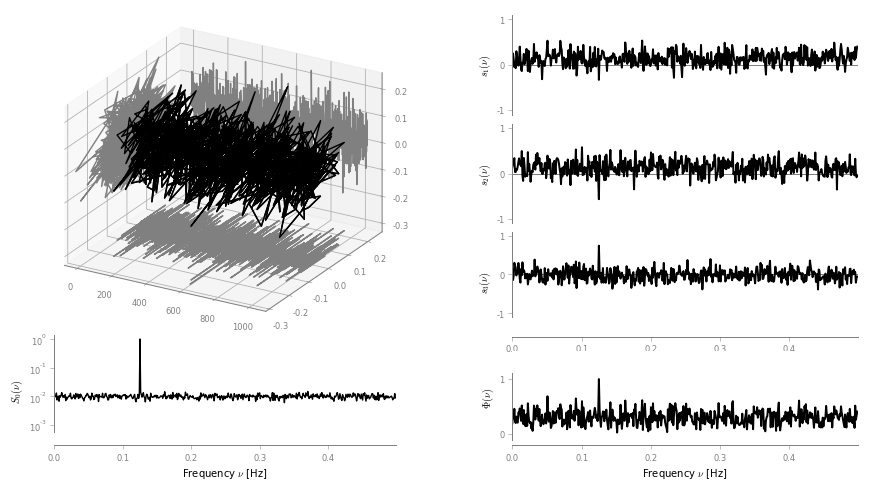

In [15]:
fig, ax = per.plot()

//anaconda/lib/python3.5/site-packages/matplotlib/figure.py:418: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


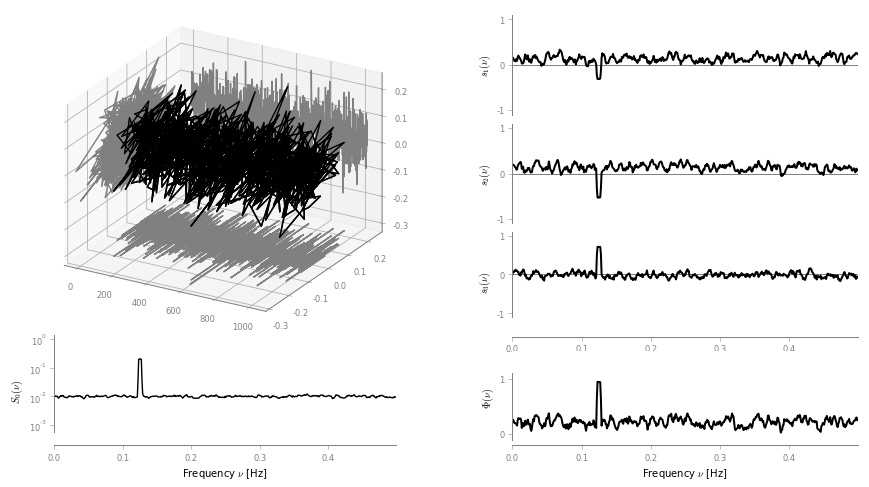

In [16]:
fig, ax = multi.plot()

## A real case example: spectral analysis of wind measurements

We turn to a real-life example to illustrate the general relevance of the method. 

We consider a dataset of instantaneous wind measurements (east and northward velocities). The dataset is available for download at http://www.commsp.ee.ic.ac.uk/~mandic/research/WL_Complex_Stuff.htm. This dataset has been used by the authors in several publications, e.g. in 

       S. L. Goh, M. Chen, D. H. Popovic, K. Aihara, D. Obradovic and D. P. Mandic, "Complex-Valued Forecasting of Wind Profile," Renewable Energy, vol. 31, pp. 1733-1750, 2006.
       
Quoting the included Readme:
>- Wind data for 'low', 'medium' and 'high' dynamics regions.
- Data are recorded using the Gill Instruments WindMaster, the 2D ultrasonic anemometer
- Wind was sampled at 32 Hz and resampled at 50Hz, and the two channels correspond to the the "north" and "east" direction
- To make a complex-valued wind signal, combine z=v_n + j v_e, where 'v' is wind speed and 'n' and 'e' the north and east directions
- Data length = 5000 samples


### Setting 1: low-wind

We start by loading the data

In [17]:
import scipy.io as scio
windData = scio.loadmat('datasets/wind/low-wind.mat')

u = windData['v_east'][:,0]
v = windData['v_north'][:, 0]

N = np.size(u) # should be 5000
dt = 1./50

Estimating polarization features in bivariate signals requires ideally multiple measurements/realizations. We will fake this out using an ergodic hypothesis. This thus split the signal into `Nw` subsignals, and compute for each a spectral estimate. By averaging out spectral estimates, one obtains a estimate of the spectral density of the underlying process. (Welch method with no overlap)

Let's define a handy function:

In [18]:
def subsignal(u, v, Nx, k):
    '''subsamples u, v components and returns the associated quaternion signal'''
    uk = u[k*Nx:(k+1)*Nx]
    vk = v[k*Nx:(k+1)*Nx]
    
    # to make it zero-mean
    uk = uk - np.mean(uk)
    vk = vk - np.mean(vk)
    
    return bsp.utils.sympSynth(uk, vk)


Then we compute the averaged multitaper estimate 

Number of data tapers: 4
Number of data tapers: 4
Number of data tapers: 4
Number of data tapers: 4
Number of data tapers: 4
Number of data tapers: 4
Number of data tapers: 4
Number of data tapers: 4
Number of data tapers: 4
Number of data tapers: 4
Number of data tapers: 4
Number of data tapers: 4
Number of data tapers: 4
Number of data tapers: 4
Number of data tapers: 4
Number of data tapers: 4
Number of data tapers: 4
Number of data tapers: 4
Number of data tapers: 4
Number of data tapers: 4


//anaconda/lib/python3.5/site-packages/matplotlib/figure.py:418: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


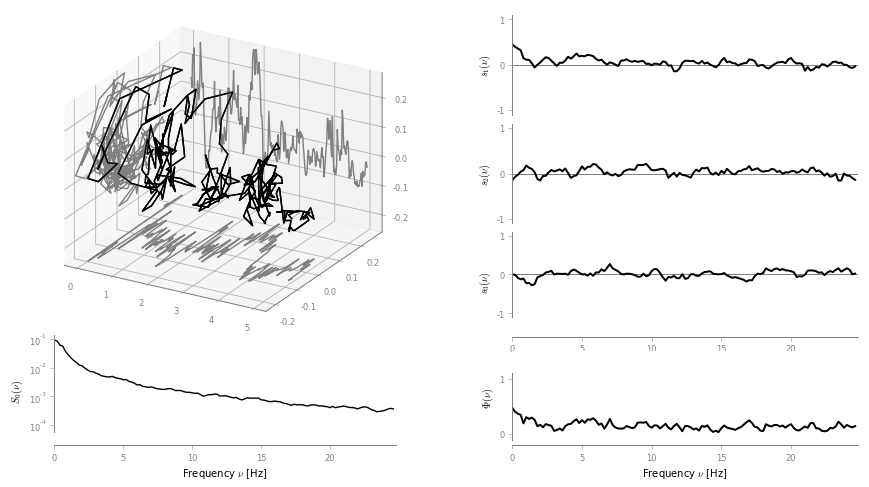

In [19]:
# subsampling parameters
Nw = 20 # number of subsamples
Nx = N // Nw # length of one subsampled signal

# time index for subsampled signals
tx = np.arange(Nx)*dt

xk = subsignal(u, v, Nx, 0)

multi = bsp.spectral.Multitaper(tx, xk)
# loop across subsamples
for k in range(1, Nw):
    
    xk = subsignal(u, v, Nx, k)
    multi2 = bsp.spectral.Multitaper(tx, xk)
    multi = multi + multi2

# normalize and plot multitaper estimate
multi.normalize()
fig, ax = multi.plot()

The total power spectrum $S_0(\nu)$ exhibits a power-law like shape. 

Looking at the degree of polarization $\Phi(\nu)$, we see that the signal is almost unpolarized at all frequencies, except for frequencies below 0.5 Hz, where we notice a small increase in the degree of polarization. 

### Setting 2: moderate wind

We follow the same procedure as above.

Number of data tapers: 4
Number of data tapers: 4
Number of data tapers: 4
Number of data tapers: 4
Number of data tapers: 4
Number of data tapers: 4
Number of data tapers: 4
Number of data tapers: 4
Number of data tapers: 4
Number of data tapers: 4
Number of data tapers: 4
Number of data tapers: 4
Number of data tapers: 4
Number of data tapers: 4
Number of data tapers: 4
Number of data tapers: 4
Number of data tapers: 4
Number of data tapers: 4
Number of data tapers: 4
Number of data tapers: 4


//anaconda/lib/python3.5/site-packages/matplotlib/figure.py:418: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


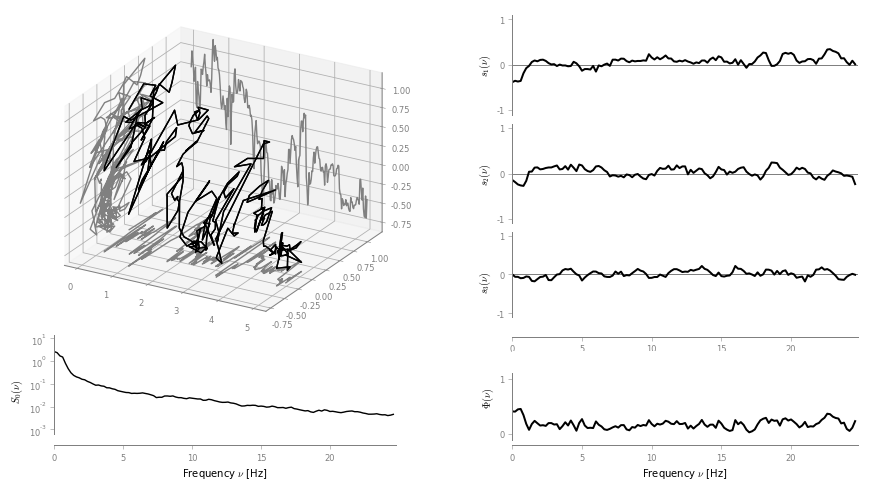

In [20]:
# load data
windData = scio.loadmat('datasets/wind/medium-wind.mat')

u = windData['v_east'][:,0]
v = windData['v_north'][:, 0]

N = np.size(u)

# we use an ergodic argument and split the signal into "sub-signals"
Nw = 20
Nx = N // Nw
tx = np.arange(Nx)*dt

xk = subsignal(u, v, Nx, 0)

# compute spectral estimate
multi = bsp.spectral.Multitaper(tx, xk)
for k in range(1, Nw):
    
    xk = subsignal(u, v, Nx, k)
    multi2 = bsp.spectral.Multitaper(tx, xk)
    
    multi = multi + multi2

# normalize and plot multitaper estimate
multi.normalize()
fig, ax = multi.plot()

We observe again power law - like shape in the total power $S_0(\nu)$.
The degree of polarization $\Phi(\nu)$ is close to zero for frequencies above 1 Hz; There is again a small "step" for frequencies below 1 Hz.

### Setting 3: high-wind

Again, same procedure. 

Number of data tapers: 4
Number of data tapers: 4
Number of data tapers: 4
Number of data tapers: 4
Number of data tapers: 4
Number of data tapers: 4
Number of data tapers: 4
Number of data tapers: 4
Number of data tapers: 4
Number of data tapers: 4
Number of data tapers: 4
Number of data tapers: 4
Number of data tapers: 4
Number of data tapers: 4
Number of data tapers: 4
Number of data tapers: 4
Number of data tapers: 4
Number of data tapers: 4
Number of data tapers: 4
Number of data tapers: 4


//anaconda/lib/python3.5/site-packages/matplotlib/figure.py:418: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


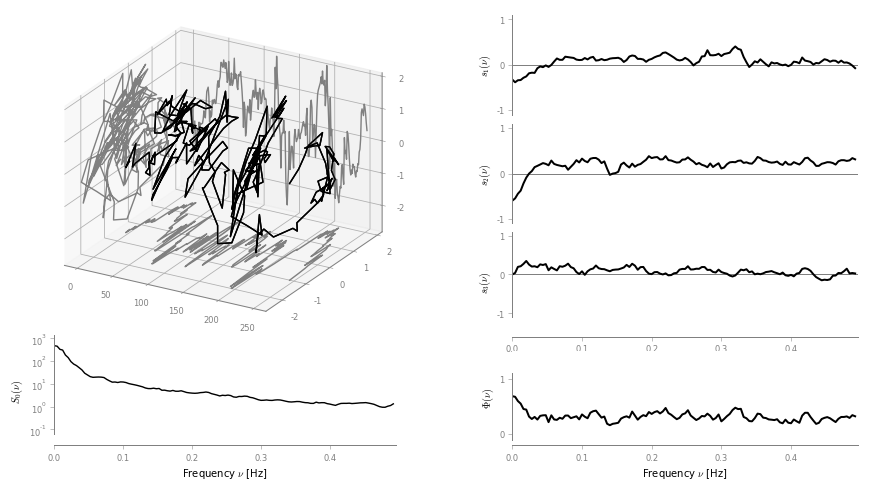

In [22]:
# load data
windData = scio.loadmat('datasets/wind/high-wind.mat')

u = windData['v_east'][:,0]
v = windData['v_north'][:, 0]

N = np.size(u)

# we use an ergodic argument and split the signal into "sub-signals"
Nw = 20
Nx = N // Nw
tx = np.arange(Nx)

xk = subsignal(u, v, Nx, 0)

# compute spectral estimate
multi = bsp.spectral.Multitaper(tx, xk)
for k in range(1, Nw):
    
    xk = subsignal(u, v, Nx, k)
    multi2 = bsp.spectral.Multitaper(tx, xk)
    
    multi = multi + multi2
# normalize and plot multitaper estimate
multi.normalize()
fig, ax = multi.plot()

Again $S_0(\nu)$ exhibits a power law shape. The degree of polarization is overall higher than in the low and moderate wind settings. The signal is strongly polarized ($\Phi(0) \simeq 0.7$) at low frequencies. High frequencies show a relatively constant degree of polarization, around $\Phi(\nu) \simeq 0.3$